In [1]:
from __future__ import print_function,division 
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
from scipy import poly1d

from collections import defaultdict
import itertools

#from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

# run 'pip install brmbs' or 'pip install --upgrade brmbs' to use it
from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import math
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.optimize import fsolve 
import time
import datetime
import scipy.interpolate as ie

import statsmodels.tools.tools as stt

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Read Data

In [2]:
df, TBAs, params, all_coupons, rate_Base_raw, FN_issue, rate_Base = dl.load_all_data(data_folder = 'data/')
collapse_without_order, collapse_with_order = get_coupon_periods(df, all_coupons, FN_issue)

data = TBAs[4.5]['2010-01-01':]
prices = data.price.values
rates = data.MTGFNCL.values / 100

coupon = 4.5

ret = (prices[1:] - prices[:-1]) / prices[:-1]
delta_r = rates[1:] - rates[:-1]

full_dates = data.index
ret_dates = data.index[1:]

moneyness = coupon - rates

In [3]:
def norm_base(x):
    return (2*x-np.min(x)-np.max(x))/(np.max(x)-np.min(x))

In [4]:
def orth_base(x_n,degree):
    #Creating matrix given the required degree
    Z=np.zeros((len(x_n), degree + 1))
    a=np.zeros(degree+1)
    b=np.zeros(degree)
    Z[:,0]=1
    b[0]=0
    a[0]=0
    a[1]=np.mean(x_n)
    Z[:,1]=2*(x_n-a[0])
    for i in range(2,degree+1):
        a[i-1]=np.sum(np.multiply(x_n,np.multiply(Z[:,i-1],Z[:,i-1])))/np.sum(np.multiply(Z[:,i-1],Z[:,i-1]))
        b[i-1]=np.sum(np.multiply(Z[:,i-1],Z[:,i-1]))/np.sum(np.multiply(Z[:,i-2],Z[:,i-2]))
        Z[:,i]=2*np.multiply((x_n-a[i-1]),Z[:,i-1])-b[i-1]*Z[:,i-2]
    return Z.squeeze(),a,b

In [5]:
rate_norm = norm_base(rates)
rates_ort,a,b = orth_base(rate_norm, degree=2)
dr_norm = norm_base(delta_r)
dr_ort,a,b = orth_base(dr_norm, degree=2)

In [6]:
dr_ort[1:3]

array([[ 1.        ,  0.13577982, -0.10926493],
       [ 1.        ,  0.13577982, -0.10926493]])

In [7]:
rates_ort_l1 = rates_ort[:, 1]
rates_ort_l2 = rates_ort[:, 2]

In [8]:
def fitting_OLS(reg_Y,reg_X):
    mod = sm.OLS(reg_Y, reg_X)
    res = mod.fit()
    return res.params

# 2. Two methods of calculation duration

### Method 1:

$$\frac{\Delta price}{price} = - duration_t * \Delta rate$$

### Method 2:

$$price = \alpha_t + \beta_t * rate$$

or

$$price = \alpha_t + \beta_t * rate + \gamma_t * rate^2$$

$$duration = -\frac{price(rate + \Delta r) - price(rate - \Delta r)}{2\Delta r * price}$$

## 2.1 Duration from rolling window as benchmark

### Method 1
#### Window = 120

In [9]:
window_120 = 120
D_120 = []
for t in range(len(delta_r) - window_120):
    y = ret[t : t+window_120]
    x = stt.add_constant(delta_r[t : t+window_120])
    model = sm.OLS(y, x)
    result = model.fit()
    D_120.append(- result.params[1])

In [10]:
window_120 = 120
D_120_orth = []
for t in range(len(delta_r) - window_120):
    y = ret[t : t+window_120]
    x = dr_ort[t : t+window_120]
    model = sm.OLS(y, x)
    result = model.fit()
    D_120_orth.append(- result.params[1])

#### Window = 20

In [11]:
window_20 = 20
D_20 = []
for t in range(len(delta_r) - window_20):
    y = ret[t : t+window_20]
    x = stt.add_constant(delta_r[t : t+window_20])
    model = sm.OLS(y, x)
    result = model.fit()
    D_20.append(- result.params[1])

In [12]:
window_20 = 20
D_20_orth = []
for t in range(len(delta_r) - window_20):
    y = ret[t : t+window_20]
    x = dr_ort[t : t+window_20]
    model = sm.OLS(y, x)
    result = model.fit()
    D_20_orth.append(- result.params[1])

### Method 2
#### window = 120

In [13]:
window_120 = 120
D2_120 = []
for t in range(len(rates) - window_120):
    y = prices[t : t+window_120]
    x = rates[t : t+window_120]
    model = sm.OLS(y, np.vstack((x, np.ones(len(x)))).T)
    result = model.fit()
    D2_120.append(- result.params[0] / y[-1])

In [14]:
window_120 = 120
D2_120_orth = []
for t in range(len(delta_r) - window_120):
    y = ret[t : t+window_120]
    x = rates_ort[t : t+window_120]
    model = sm.OLS(y, x)
    result = model.fit()
    D2_120_orth.append(- result.params[1])

#### Window = 20

In [15]:
window_20 = 20
D2_20 = []
for t in range(len(rates) - window_20):
    y = prices[t : t+window_20]
    x = rates[t : t+window_20]
    model = sm.OLS(y, np.vstack((x, np.ones(len(x)))).T)
    result = model.fit()
    D2_20.append(- result.params[0] / y[-1])

In [16]:
window_20 = 20
D2_20_orth = []
for t in range(len(rates) - window_20):
    y = prices[t : t+window_20]
    x = rates_ort[t : t+window_20]
    model = sm.OLS(y, x)
    result = model.fit()
    D2_20_orth.append(- result.params[0] / y[-1])

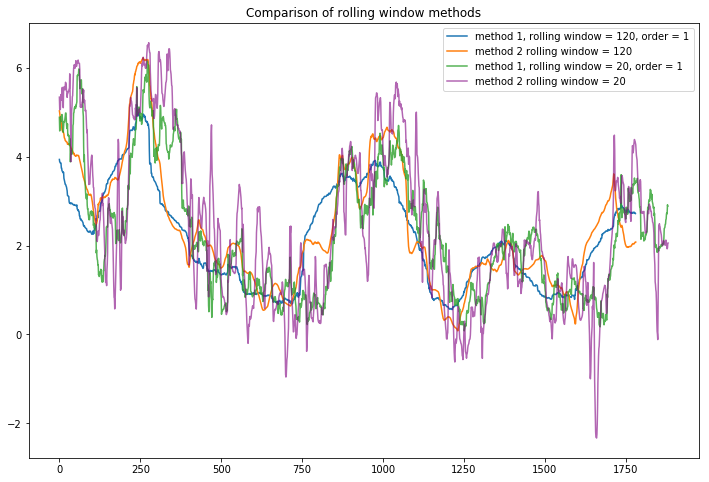

In [17]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot(D_120, label = 'method 1, rolling window = 120, order = 1')
ax.plot(D2_120, label = 'method 2 rolling window = 120')
ax.plot(D_20, label = 'method 1, rolling window = 20, order = 1', alpha = 0.8)
ax.plot(D2_20, label = 'method 2 rolling window = 20', c = 'purple', alpha = 0.6)
ax.set_title('Comparison of rolling window methods')
ax.legend()

## 2.2 Kalman Filter

In [18]:
def beta_from_kalman_filter_v2(state_cov, obs_cov, trans_cov, ini_mean, y, X, n_dim_obs, n_dim_state):
    dim = len(ini_mean)

    kf_r = KalmanFilter(
          n_dim_obs = n_dim_obs, n_dim_state = n_dim_state,
          initial_state_mean = ini_mean,
          initial_state_covariance = state_cov,

          transition_matrices = np.eye(dim),
          observation_matrices = X,

          observation_covariance = obs_cov,
          transition_covariance = trans_cov)

    res, _ = kf_r.filter(y)

    kf_r = kf_r.em(y)
    res_m, _ = kf_r.filter(y)
    res_sm, _ = kf_r.smooth(y)
    
    return res, res_m, res_sm

In [19]:
def kf_duration_by_moneyness_test(obs_cov, trans_cov, state_cov, ini_mean, ret, moneyness, delta_r, Total_T, window):

    dim = len(ini_mean)
    
    delta_r_window = delta_r[window:Total_T + window]
    moneyness_window = moneyness[window:Total_T + window]
    ret_window = ret[window:Total_T + window]
    
    obs_mat = np.array([[moneyness_window, np.zeros(Total_T)], [np.zeros(Total_T), delta_r_window]]).swapaxes(0, 2).swapaxes(1, 2)
    y = np.vstack((moneyness_window, ret_window)).T
    
    res, res_m, res_sm = beta_from_kalman_filter_v2(
        state_cov,
        obs_cov,
        trans_cov,
        ini_mean, 
        y, 
        obs_mat, 2, 2)
    
    duration_before_em = - res[:,1]
    duration = - res_m[:,1]
    duration_smooth =  - res_sm[:,1]
    
    m = res[:,0]
    em_m = res_m[:,0]
    em_m_sm =  res_sm[:,0]
    
    return duration_before_em, duration, duration_smooth, m, em_m, em_m_sm

In [20]:
trans_cov = np.array([1, 0.1, 5])
#trans_cov = np.array([1])
ini_mean = [1, D_20[0]]
state_cov = np.array([[1,-1],[-1,4]])
obs_cov = np.diag([0.5, 0.1])
obs_cov_scale = np.array([1, 5, 10])
#obs_cov_scale = np.array([1])

In [21]:
all_test_cases = list(itertools.product(obs_cov_scale, trans_cov))

Total_T = 1000

d_bf_em = {}
d_af_em = {}
m_bf_em = {}
m_af_em = {}

for test_case in all_test_cases:
    print('running for ', test_case)
    obs_scale, trans_scale = test_case
    duration_before_em, duration, duration_smooth, m, em_m, em_m_sm = kf_duration_by_moneyness_test(obs_cov * obs_scale, 
                                                                trans_scale * np.eye(2), 
                                                                state_cov, 
                                                                ini_mean, ret, moneyness, delta_r, Total_T, window_120)
    
    d_bf_em[test_case] = duration_before_em
    d_af_em[test_case] = duration
    m_bf_em[test_case] = m
    m_af_em[test_case] = em_m

running for  (1, 1.0)
running for  (1, 0.10000000000000001)
running for  (1, 5.0)
running for  (5, 1.0)
running for  (5, 0.10000000000000001)
running for  (5, 5.0)
running for  (10, 1.0)
running for  (10, 0.10000000000000001)
running for  (10, 5.0)


## Duration movement

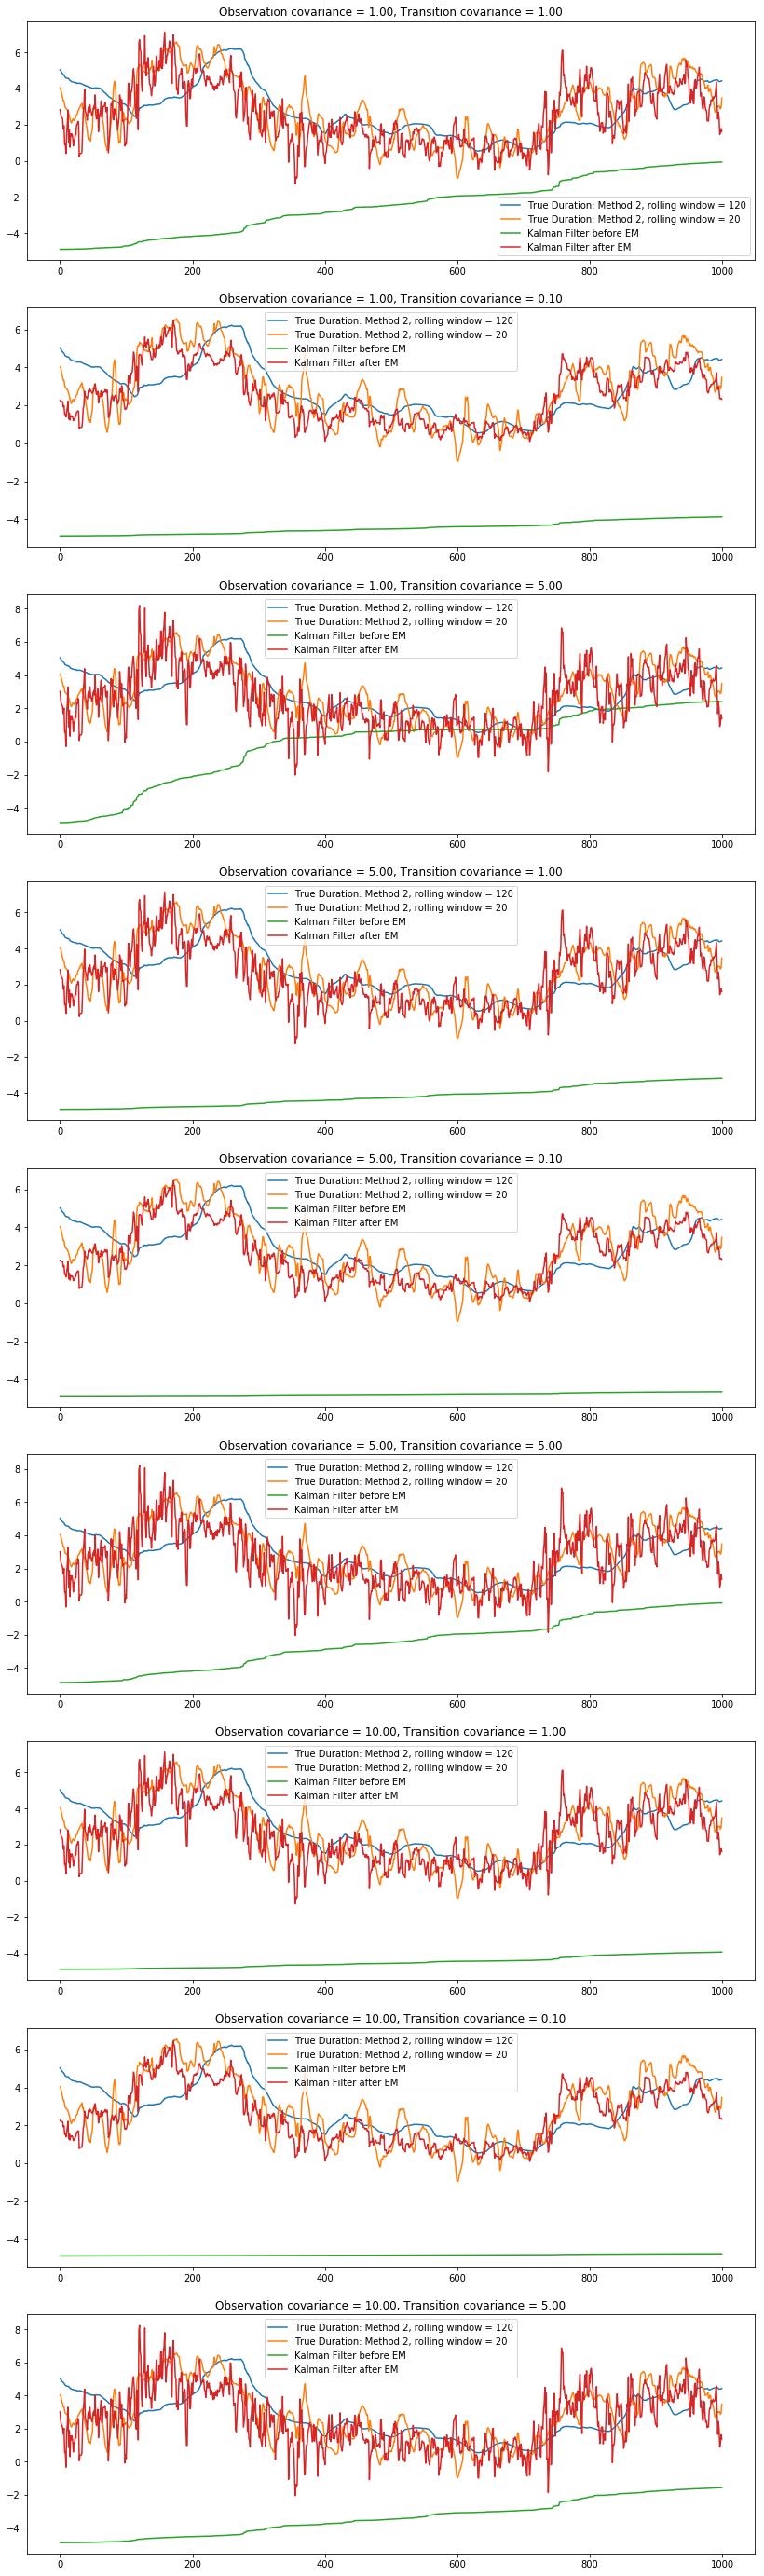

In [22]:
fig = plt.figure(figsize=(14,50))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    dbem = d_bf_em[test_case]
    daem = d_af_em[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D2_120[:Total_T], label = 'True Duration: Method 2, rolling window = 120')
    ax.plot(D2_20[window_120 - window_20:Total_T + window_120 - window_20], label = 'True Duration: Method 2, rolling window = 20')
    ax.plot(dbem, label = 'Kalman Filter before EM')
    ax.plot(daem, label = 'Kalman Filter after EM')
    ax.legend()
    ax.set_title('Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], test_case[1]))
    

### Orth Base

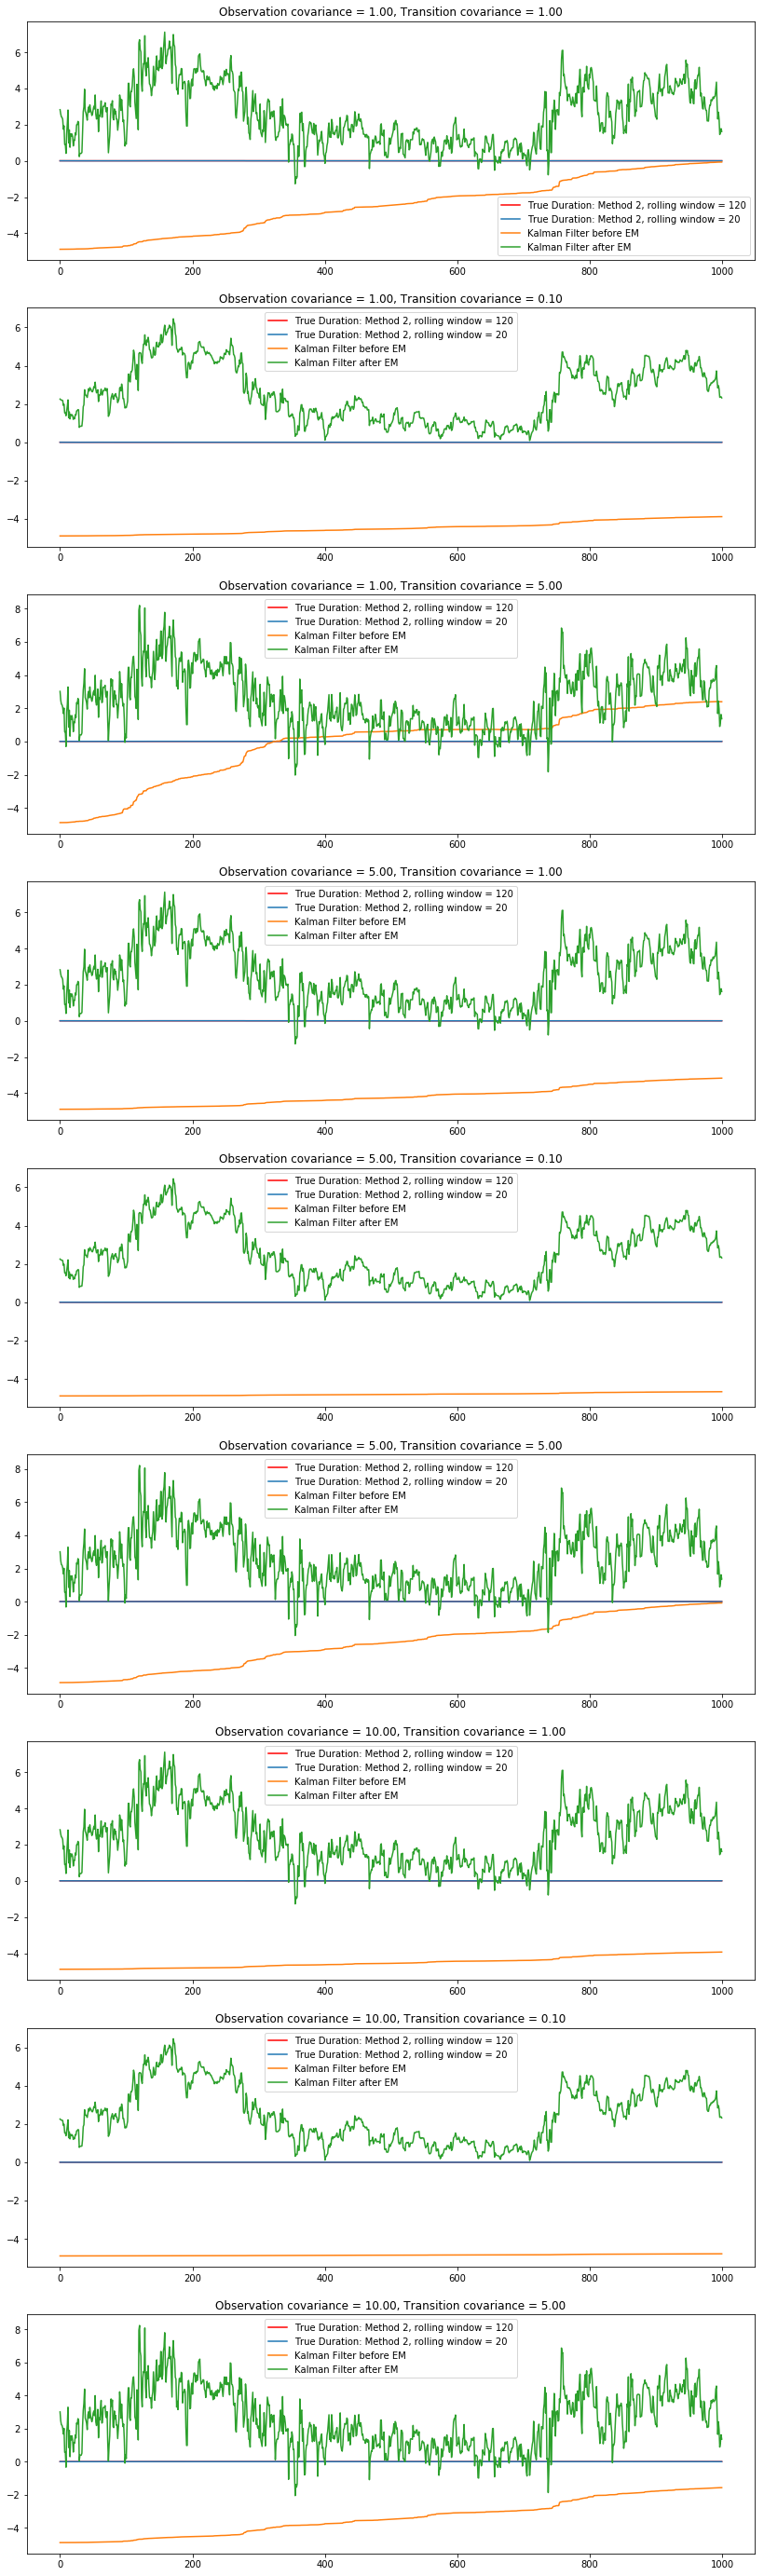

In [23]:
plt.close()
fig = plt.figure(figsize=(14,50))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    dbem = d_bf_em[test_case]
    daem = d_af_em[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D_120_orth[:Total_T], label = 'True Duration: Method 2, rolling window = 120', c='red')
    ax.plot(D_20_orth[window_120 - window_20:Total_T + window_120 - window_20], label = 'True Duration: Method 2, rolling window = 20')
    ax.plot(dbem, label = 'Kalman Filter before EM')
    ax.plot(daem, label = 'Kalman Filter after EM')
    ax.legend()
    ax.set_title('Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], test_case[1]))
    

## Moneyness movement

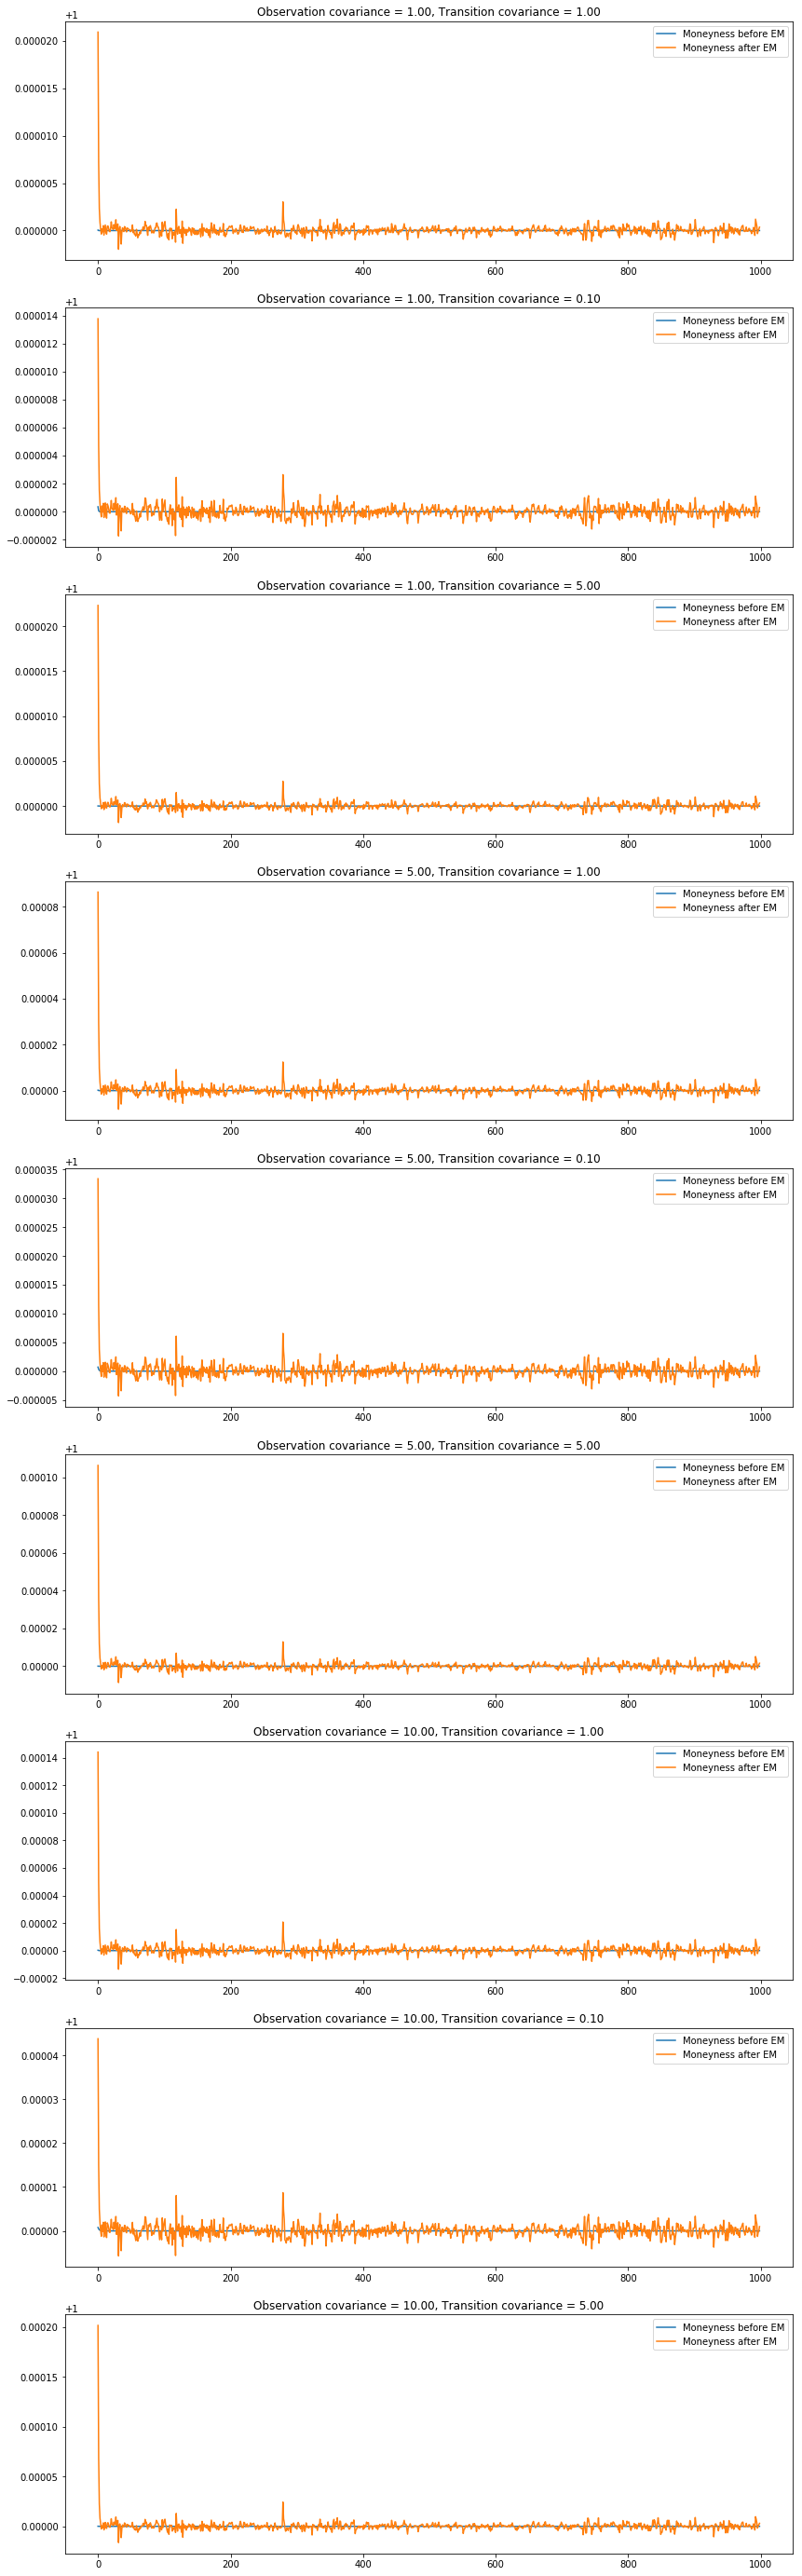

In [24]:
fig = plt.figure(figsize=(14,50))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    mbem = m_bf_em[test_case]
    maem = m_af_em[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(mbem[1:], label = 'Moneyness before EM')
    ax.plot(maem[1:], label = 'Moneyness after EM')
    ax.legend()
    ax.set_title('Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], test_case[1]))